# Public notebook on the usage of higher order Stencils in the Jacobi and SOR method, as well as extras

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
""" Remove the quotation marks '' and run only if following dependencies are not installed.

pip install numpy
pip install Cython
pip install matplotlib"""

" Remove the quotation marks '' and run only if following dependencies are not installed.\n\npip install numpy\npip install Cython\npip install matplotlib"

In [3]:
%load_ext Cython

In [4]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
cimport cython
from cython.parallel import prange
cimport numpy as np
import operator
from libc.math cimport sqrt
from libc.math cimport pi




""" Iterative Methods. Jacobi and SOR . !!!: Following methods use the 8-stenicl (8 nearest neighbour interaction)"""
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef void jacobi_iteration(int n, int m, double[:,:] new_array, double[:,:] old_array, double[:,:] mask) nogil:
    cdef int i, j
    cdef double tmp
    for i in prange(1, n-1, nogil=True):
        for j in prange(1, m-1):
            if not mask[i, j]:
                new_array[i, j] = 0.2*(old_array[i-1,j]+old_array[i+1,j]+old_array[i,j-1]+old_array[i,j+1]) + \
                0.05*(old_array[i+1,j+1]+old_array[i+1,j-1]+old_array[i-1,j+1]+old_array[i-1,j-1])


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef tuple jacobi_fx(double[:,:] A, double[:,:] mask, int max_iterations, double error):
    cdef int i, n, m, iteration
    cdef double norm, norm_prev, tmp_error
    n, m = A.shape[0], A.shape[1]
    cdef double[:,:] new_arr = A.copy()
    cdef double[:,:] old_arr = A.copy()
    norm_prev = 0
    norm = 0
    iteration = 0
    for i in range(max_iterations):
        norm = np.linalg.norm(old_arr)
        jacobi_iteration(n, m, new_arr, old_arr, mask)
        old_arr = new_arr
        tmp_error = abs(norm - norm_prev)
        norm_prev = norm
        iteration = iteration + 1
        if tmp_error < error:
            break
    return (new_arr, tmp_error, iteration)




@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef void sor(int n, int m, double[:,:] GS_arr, double[:,:] mask, double alpha) nogil:
    cdef int i, j
    for i in prange(1, n-1, nogil=True):
        for j in prange(1, m-1):
            if not mask[i, j]:
                GS_arr[i,j] = (1-alpha)*GS_arr[i,j] + 0.2*alpha*(GS_arr[i+1,j]+GS_arr[i,j+1]+GS_arr[i-1,j]+GS_arr[i,j-1]) + \
                0.05*alpha*(GS_arr[i+1,j+1] + GS_arr[i+1,j-1] + GS_arr[i-1,j+1] + GS_arr[i-1,j-1])


                    
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef tuple sor_fx(double[:,:] A, double[:,:] mask, int max_iterations, double error, double alpha):
    cdef int i, n, m, iteration
    cdef double norm, norm_prev, tmp_error
    norm_prev = 0
    norm = 0
    iteration = 0
    n, m = A.shape[0], A.shape[1]
    cdef double[:,:] GS_matrix = A.copy()
    alpha_ideal = 1.976/(1+(pi/sqrt(n*m)))
    if alpha == 0:
        alpha = alpha_ideal
    for i in range(max_iterations):
        norm = np.linalg.norm(GS_matrix)
        sor(n, m, GS_matrix, mask, alpha)
        tmp_error = abs(norm - norm_prev)
        norm_prev = norm
        iteration = iteration + 1
        if tmp_error < error:
            break
    return (GS_matrix, tmp_error, iteration)
                                                                                                

    
    
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef tuple up_cycle(double [:,:] potential, double[:,:] mask, int total_samples, int inner_iterations, double convergance, double index_truncation_factor):
    

    cdef list sample_masks = []
    cdef list modifiable_potential = []
    cdef list data = []
    cdef int number, length, pot_count
    

    modifiable_potential.append(coarsen_potential(potential, index_truncation_factor*(1/total_samples)))
    sample_masks.append(mask)
    

    for number in range(total_samples):
        sample_masks.append(coarsen_potential(mask, index_truncation_factor*(1/(number+1))))
        
    length = len(sample_masks) - 1
    pot_count = 0
    
    while length>=0:
        set_dirichlet(modifiable_potential[pot_count], sample_masks[length])


        result = sor_fx(modifiable_potential[pot_count], sample_masks[length], inner_iterations, convergance, 0.0)
        
        if length>0:
            modifiable_potential.append(interpolate_potential(result[0], sample_masks[length-1].shape[0], sample_masks[length-1].shape[1]))
            data.append(result[1])
            data.append(result[2])
        
        length = length-1
        
        pot_count = pot_count +1
    return modifiable_potential, data


""" Boundary Condition handeling methods """
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef void set_dirichlet(double[:,:] array, double[:,:] mask) nogil:
    cdef int i, j
    cdef int rows = array.shape[0]
    cdef int cols = array.shape[1]
    for i in range(rows):
        for j in range(cols):
            if mask[i, j]:
                array[i, j] = mask[i, j]                                                                                                
                                                                                                

        
""" Index projection methods """
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef double[:, :] coarsen_potential(double[:, :] potential, double index_truncation_factor):
    cdef int rows, cols, i, j, inv
    rows = <int>(potential.shape[0] * index_truncation_factor)
    cols = <int>(potential.shape[1] * index_truncation_factor)
    cdef double[:,:] coarsened_potential = np.zeros((rows, cols), dtype=np.float64)
    inv = <int>(1 / index_truncation_factor)
    for i in range(rows):
        for j in range(cols):
            coarsened_potential[i, j] = np.mean(potential[i * inv:i * inv + inv, j * inv:j * inv + inv])
    return coarsened_potential




@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef double[:, :] interpolate_potential(double[:, :] potential, int target_height, int target_width):

    cdef double[:, :] smoothed_potential
    smoothed_potential = np.zeros((target_height, target_width), dtype=np.float64)

    cdef int i, j, ii, jj
    cdef double height_ratio, width_ratio
    height_ratio = potential.shape[0] / target_height
    width_ratio = potential.shape[1] / target_width

    for i in range(target_height):
        for j in range(target_width):
            ii = <int>(i * height_ratio)
            jj = <int>(j * width_ratio)
            smoothed_potential[i, j] = potential[ii, jj]
    return smoothed_potential



""" Methods to Create primitive Shapes with index algebra """

operators = {'>': operator.gt,
        '<': operator.lt,
        '>=': operator.ge,
        '<=': operator.le,
             '==': operator.eq}


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef void create_circle(double[:,:] matrix, double[:,:] mask, double x, double y, double radius, double value, double m_value, str param):
    cdef int i, j
    cdef int rows = matrix.shape[0]
    cdef int cols = matrix.shape[1]
    for i in range(rows):
        for j in range(cols):
            if operators[param](((i-y)*(i-y) + (j-x)*(j-x)), radius*radius):
                matrix[i, j] = value
                mask[i, j] = m_value

                
                
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef void create_rectangle(double[:,:] matrix, double[:,:] mask, double x, double y, double width, double height, double value, double m_value, str param):
    cdef int i, j
    cdef int rows = matrix.shape[0]
    cdef int cols = matrix.shape[1]
    cdef double left = x - width / 2
    cdef double right = x + width / 2
    cdef double top = y - height / 2
    cdef double bottom = y + height / 2
    for i in range(rows):
        for j in range(cols):
            if operators[param](left, j) and operators[param](j, right) and operators[param](top, i) and operators[param](i, bottom):
                matrix[i, j] = value
                mask[i, j] = m_value

             

                



In [5]:
"""!!!"""
"""!!MANDATORY VARIABLES!!"""
"""!!!"""
res = (2160, 3840)
potential = np.zeros(res, dtype=float) 
mask = np.zeros(res, dtype=float)
"""The names 'potential' and 'mask' are variables that go into the keyword arguments of functions like create_circle or create_rectangle """

"""Optional variables"""
"""!!Check if in usage. Probably so!!"""
center_y, center_x = potential.shape[0]//2, potential.shape[1]//2
radius = 1000
hollow_radius = 800
small_radius = 600


"""Let's put the boundary conditions"""

create_circle(potential, mask, center_x, center_y, radius, 100, 100, '<=')
create_circle(potential, mask, center_x, center_y, hollow_radius, 0., 0, '<=')
create_circle(potential, mask, center_x, center_y, small_radius, -100., -100, '<=')
create_rectangle(potential, mask, center_x, center_y, 150, 1250, 0., 0, '<=')
create_rectangle(potential, mask, center_x, center_y, 1250, 150, 0., 0, '<=')
create_rectangle(potential, mask, center_x*0.5-350, center_y, 200, 1980, -100, -100, '<=')
create_rectangle(potential, mask, center_x*1.5+350, center_y, 200, 1980, -100., -100, '<=')
create_circle(potential, mask, center_x, center_y, 30, -100, -100, '<=')
create_circle(potential, mask, center_x+200, center_y, 30, 120, 120, '<=')
create_circle(potential, mask, center_x-200, center_y, 30, 120, 120, '<=')
create_circle(potential, mask, center_x, center_y+200, 30, 120, 120, '<=')
create_circle(potential, mask, center_x, center_y-200, 30, 120, 120, '<=')
create_circle(potential, mask, center_x+400, center_y, 30, 120, 120, '<=')
create_circle(potential, mask, center_x-400, center_y, 30, 120, 120, '<=')
create_circle(potential, mask, center_x, center_y+400, 30, 120, 120, '<=')
create_circle(potential, mask, center_x, center_y-400, 30, 120, 120, '<=')

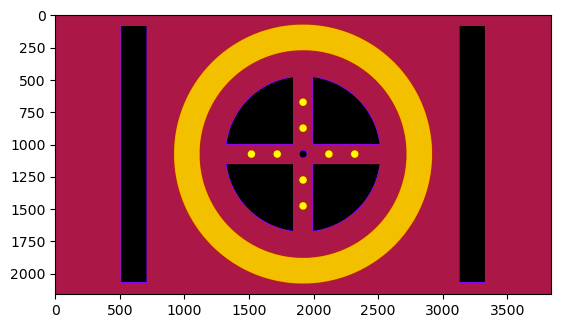

In [6]:
plt.imshow(potential, cmap='gnuplot')

In [7]:
%%time
result = sor_fx(potential, mask, 10000, 0.1, 1.976)

Wall time: 1min 27s


In [8]:
result, np.linalg.norm(result[0]), result[0].nbytes

((<MemoryView of 'array' at 0x1f38c9006c0>, 0.09987209344399162, 2868),
 208789.41938818252,
 66355200)

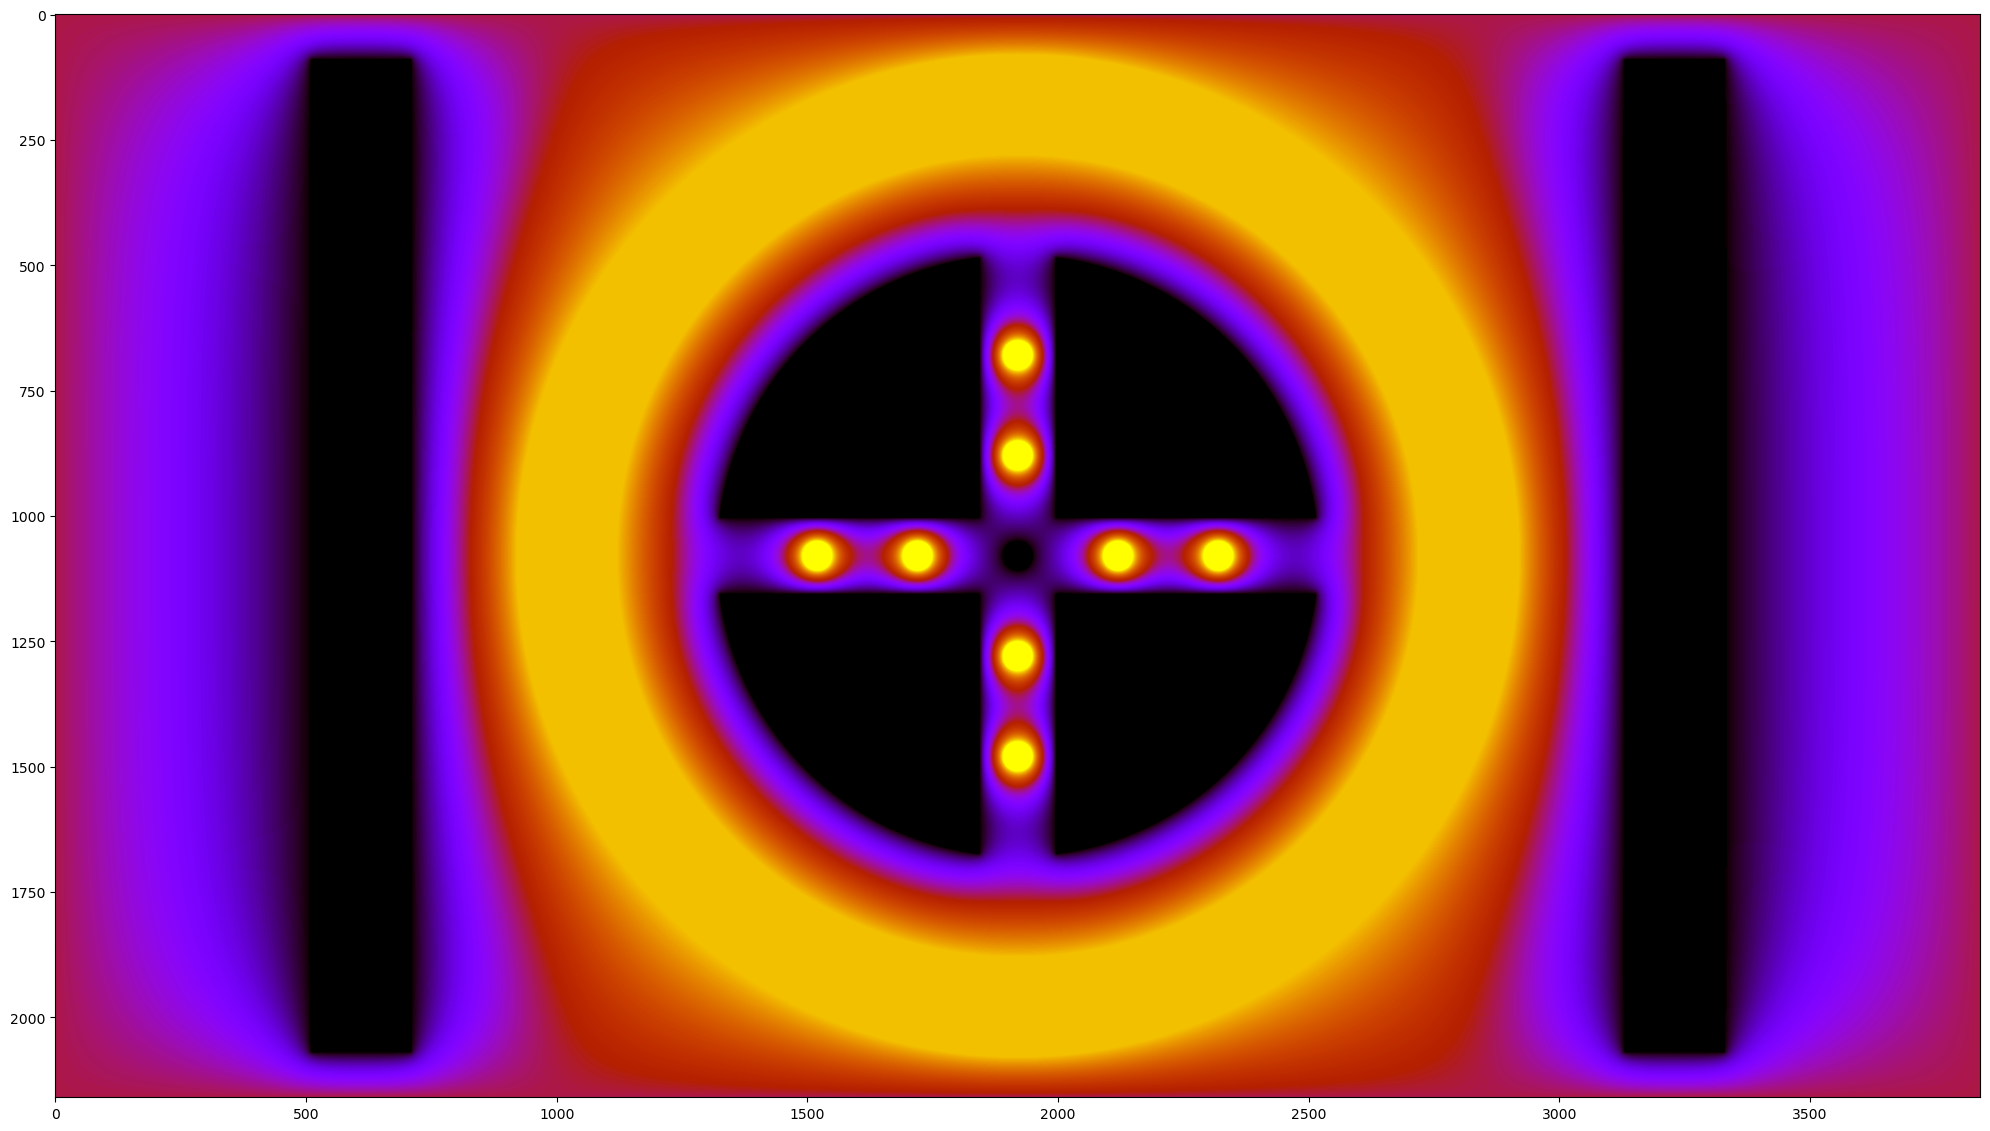

In [9]:
plt.figure(figsize=(25, 14.0625))
plt.imshow(result[0], cmap='gnuplot')

In [ ]:
#run to save as desktop bg. 
"""
you can set cmap = '...' for more interesting graphs
'hsv'
'gnuplot'
'gnuplot2'
'viridis'
'plasma'
'inferno'
'spring'
'copper'
'gist_rainbow'
'binary'
"""
plt.imsave('name.png', result[0], cmap='gnuplot', dpi=240)

In [ ]:
fig = plt.figure(figsize=(35.55, 20))

rows = 2
cols = 1

fig.add_subplot(rows, cols, 1)
plt.imshow(cycle_result[0], cmap='gnuplot')
plt.title("lowest truncated resolution"+str(cycle_result[0].shape))
fig.add_subplot(rows, cols, 2)
plt.imshow(cycle_result[-1], cmap='gnuplot')
plt.title("original resolution"+str(cycle_result[-1].shape))
plt.show()



In [ ]:
"""
more interesting boundaries on the edges ^_^
testside = np.linspace(0.0, 8*np.pi, num=res[0])
testup = np.linspace(0.0, 8*np.pi, num=res[1])

potential[:,0]=35*(np.cos(2*testside))
potential[:,-1]=35*(np.cos(2*testside))
potential[0,:]=35*(np.cos(2*testup))
potential[-1,:]=35*(np.cos(2*testup))


import pygame

# Define the size of the window
WINDOW_SIZE = (1920, 1080)

# Create the Pygame window
pygame.init()
screen = pygame.display.set_mode(WINDOW_SIZE)
pygame.display.set_caption("Potential")

# Define some colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)

# Define a color map to improve the color scheme
color_map = [(0, 0, 255 * i // 256) for i in range(256)]

# Start the main loop
running = True
while running:
    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Update the potential array
    jacobi_iteration(potential, mask)

    # Create a surface from the potential array
    surface = pygame.surfarray.make_surface(np.rot90(potential, k=1))
    surface.set_palette(color_map)

    # Scale the surface to fit the screen
    surface = pygame.transform.scale(surface, WINDOW_SIZE)

    # Draw the surface on the screen
    screen.blit(surface, (0, 0))

    # Update the screen
    pygame.display.flip()

# Quit Pygame when the main loop exits
pygame.quit()

"""

""" #to be tested
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef up_cycle_fx(double [:,:] matrix, double[:,:] mask, int total_samples, int inner_iterations, double index_truncation_factor, int max_iterations, double conv_criterion):
    iteration = 0
    error = 0
    norm = 0
    norm_prev = 0
    cdef int tmp_error
    for i in range(max_iterations):
        norm = np.linalg.norm(matrix)
        up_cycle(matrix, mask, total_samples, inner_iterations, index_truncation_factor)
        error = abs(norm-norm_prev)
        norm_prev = norm
        iteration = iteration + 1
    return matrix, error, iteration
~~~if you are a user feel free to work on this out of curiosity :)~~~       
"""

"""
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef void jacobi_iteration_2(double[:,:] A, double[:,:] mask):
    cdef int i, j, n, m
    cdef double tmp
    n, m = A.shape[0], A.shape[1]
    for i in range(1, n-1):
        for j in range(1, m-1):
            if not mask[i, j]:
                tmp = 0.2 * (A[i-1, j] + A[i+1, j] + A[i, j-1] + A[i, j+1]) + 0.05 * (A[i+1, j+1] + A[i+1, j-1] + A[i-1, j+1] + A[i-1, j-1])
                A[i, j] = tmp


                
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef tuple Jacobi_fx_2(double[:,:] A, double[:,:] mask, int max_iterations, double error):
    cdef int i, n, m, iteration
    cdef double norm, norm_prev, tmp_error
    norm_prev = 0
    norm = 0
    iteration = 0
    n, m = A.shape[0], A.shape[1]
    for i in range(max_iterations):
        norm = np.linalg.norm(A)
        jacobi_iteration_2(A, mask)
        tmp_error = abs(norm - norm_prev)
        norm_prev = norm
        iteration = iteration + 1
        if tmp_error < error:
            break
    return (A, tmp_error, iteration)


                





@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef tuple GS_solver(double[:,:] array, double[:,:] mask, int max_iter, double error_threshold):
    cdef int iteration = 0
    cdef double error, error_prev, convergance
    cdef double[:,:] arrayNEW
    error = 0
    error_prev = 0
    cdef int n, m, row, col
    n, m = array.shape[0], array.shape[1]
    arrayNEW = array
    while True:
        error_prev = np.linalg.norm(array)
        for row in prange(1, n-1, nogil=True):
            for col in range(1, m-1):
                if not mask[row,col]:
                    arrayNEW[row, col] = 0.25*(array[row+1, col] + arrayNEW[row, col-1] + array[row, col+1] + arrayNEW[row-1, col])
        error = np.linalg.norm(arrayNEW)
        convergance = abs(error-error_prev)
        if iteration > max_iter:
            break
        elif convergance < error_threshold:
            break
        else:
            convergance = 0.
            array = arrayNEW
        iteration = iteration + 1
    return (array, iteration, convergance)
"""